In [4]:
import torchvision
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms, models
from torchvision.datasets import Food101

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

  losses = []
  accuracies = []

  net.to(device)

  for e in range(epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / train_dataset_length

    print(f"Loss-ul la finalul epocii {e + 1}: {epoch_loss}")

    acc = test_acc(net, test_loader)
    print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

    losses.append(epoch_loss)
    accuracies.append(acc)

  loss_graph(losses)
  accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


Training started
Loss-ul la finalul epocii 1: 4.310900771087546
Acuratetea la finalul epocii 1 este 9.81%
Loss-ul la finalul epocii 2: 3.6225048307727272
Acuratetea la finalul epocii 2 este 20.17%
Loss-ul la finalul epocii 3: 3.2016304201875188
Acuratetea la finalul epocii 3 este 30.59%
Loss-ul la finalul epocii 4: 3.046931796618421
Acuratetea la finalul epocii 4 este 31.68%
Loss-ul la finalul epocii 5: 2.9282229592162783
Acuratetea la finalul epocii 5 este 32.13%
Loss-ul la finalul epocii 6: 2.847546188001979
Acuratetea la finalul epocii 6 este 36.55%
Loss-ul la finalul epocii 7: 2.763212729035431
Acuratetea la finalul epocii 7 este 38.73%
Loss-ul la finalul epocii 8: 2.6948497519603265
Acuratetea la finalul epocii 8 este 42.06%
Loss-ul la finalul epocii 9: 2.6695911419934566
Acuratetea la finalul epocii 9 este 44.13%
Loss-ul la finalul epocii 10: 2.6205157339454876
Acuratetea la finalul epocii 10 este 36.04%
Loss-ul la finalul epocii 11: 2.5837863021951306
Acuratetea la finalul epoci

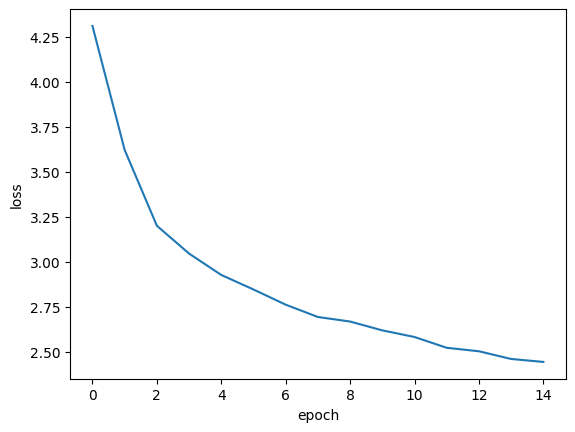

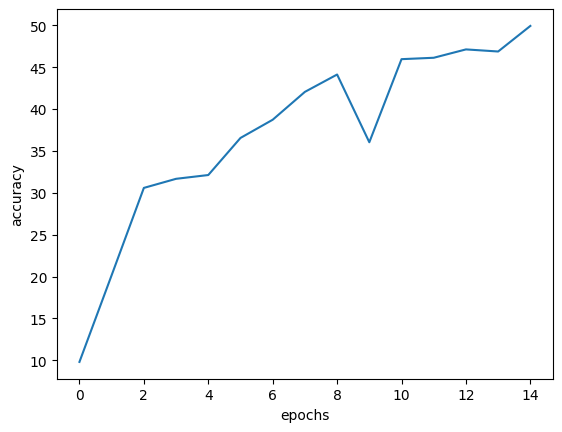

Duration of training: 334.2003680944443


In [5]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='./data', split='train', transform=transform, download=True)
test_dataset = Food101(root='./data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Freeze all layers except the final classification layer
for param in resnet.parameters():
    param.requires_grad = False

# Modify the final classification layer
num_classes = len(train_dataset.classes)
# resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 512),
    nn.LeakyReLU(),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Linear(256, num_classes)
)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

epochs = 15
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, resnet, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(resnet.state_dict(), 'resnet_model_512_4fclayers.pkl')
